## Setup and Installation

In [ ]:
#install packages and dependencies
!pip install --upgrade --quiet google-cloud-discoveryengine langchain_community langchain_google_vertexai google-cloud-aiplatform langchain-google-firestore lida llmx openai

In [ ]:
!pip install langchain langchain_google_vertexai langchain_google_community google-cloud-aiplatform langchain-google-community[vertexaisearch] --upgrade google-cloud-discoveryengine

  Using cached google_cloud_discoveryengine-0.11.14-py3-none-any.whl.metadata (5.2 kB)
Using cached google_cloud_discoveryengine-0.11.14-py3-none-any.whl (2.2 MB)
  Attempting uninstall: google-cloud-discoveryengine
    Found existing installation: google-cloud-discoveryengine 0.13.5
    Uninstalling google-cloud-discoveryengine-0.13.5:
      Successfully uninstalled google-cloud-discoveryengine-0.13.5


## Google Colab Authentication

In [ ]:
import sys

if "google.colab" in sys.modules:
    from google.colab import auth as google_auth

    google_auth.authenticate_user()

## Library Imports

In [ ]:
import pandas as pd
import vertexai
from vertexai.generative_models import (
    Content,
    FunctionDeclaration,
    GenerationConfig,
    GenerativeModel,
    Part,
    Tool,
)
from vertexai.preview.generative_models import grounding
from vertexai.preview import reasoning_engines
from google.cloud import datastore
import re

## Vertex AI Initialization

In [ ]:
PROJECT_ID = "innosights"  # @param {type:"string"}
LOCATION = "us-central1"  # @param {type:"string"}
#STAGING_BUCKET = "gs://inno_staging_1"  # @param {type:"string"}

import vertexai

vertexai.init(project=PROJECT_ID, location=LOCATION)

## Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Data Loading

In [ ]:
vis_df = pd.read_csv("/content/drive/MyDrive/IAR_ELA.csv")

In [ ]:
vis_df.head()

,Student_Name,Student_ID,Annual_Grade,Test_Grade,Grade_Level_Current,Current_Homeroom,Tested_School,Current_School,Product,Test_Scaled_Score,Student_Growth_Percentile,Subject_Category,Test_Primary_Result_Code,Year
0,"Patterson, Camryn, K.",50600824,3,3,3,--,BASE,INNO,IAR,650,--,ELA,1- Did Not Yet Meet Expectations,2020-2021
1,"Matthews, Tyshawn, D. Jr",60040913,3,3,3,--,BASE,INNO,IAR,697,--,ELA,1- Did Not Yet Meet Expectations,2020-2021
2,"Mitchell, Eliza",60054023,4,4,4,--,BASE,INNO,IAR,659,--,ELA,1- Did Not Yet Meet Expectations,2020-2021
3,"Hampton, Julian",60072349,4,4,4,--,BASE,INNO,IAR,664,--,ELA,1- Did Not Yet Meet Expectations,2020-2021
4,"McNeal, Jmariyah, S.",50732256,4,4,4,I212,BASE,INNO,IAR,679,--,ELA,1- Did Not Yet Meet Expectations,2020-2021


In [ ]:
len(vis_df)

437

## Question Generator

In [ ]:
# Dictionary to store dataset categories and their corresponding keywords based on DataFrame values
dataset_categories = {
    "IAR Mathematics": ['mathematics', 'iar'],
    "IAR ELA": ['ela', 'iar'],
    "Education": ['school', 'university', 'gpa', 'student', 'degree'],
    # Add more categories as needed
}


In [ ]:
def infer_dataframe_type(df: pd.DataFrame) -> str:
    """
    Infers the type of DataFrame based on the values within the DataFrame by matching them against predefined keyword categories.

    Args:
        df (pd.DataFrame): The DataFrame to analyze.

    Returns:
        str: The inferred category of the DataFrame, or "Unknown" if no match is found.
    """

    # Flatten the DataFrame values into a list of strings (converting all values to strings)
    all_values = df.astype(str).values.flatten()

    # Tokenize the DataFrame values (split into individual words)
    tokenized_values = [re.findall(r'\b\w+\b', value.lower()) for value in all_values]

    # Function to check if all keywords for a category are present in the tokenized DataFrame values
    def match_all_keywords(keywords):
        for keyword in keywords:
            if not any(keyword in tokens for tokens in tokenized_values):
                return False  # Return False if any keyword is missing
        return True  # Return True if all keywords are found

    # Iterate through each category and check for all required keyword matches in the DataFrame values
    for category, keywords in dataset_categories.items():
        if match_all_keywords(keywords):
            return category

    # Return "Unknown" if no category matches
    return "Unknown"


In [ ]:
# Call the function to infer the type of the DataFrame
data_type = infer_dataframe_type(vis_df)
print(data_type)  # Expected Output: "IAR ELA

IAR ELA


In [ ]:
def background_data(query:str):
    """Provides dataset-specific context for queries."""
    project_id = "innosights"  # Define the project ID
    location = "us"  # Define the location
    qa_data_store_id = "qa-data-tool_1724784014475"
    qa_data_store_path = f"projects/{project_id}/locations/{location}/collections/default_collection/dataStores/{qa_data_store_id}"

    # Initialize the model
    model = GenerativeModel("gemini-2.0-flash-exp")

    # Initialize the retrieval tool with the specific data store path
    qa_data_tool = Tool.from_retrieval(
        grounding.Retrieval(grounding.VertexAISearch(datastore=qa_data_store_path))
    )

    # Generate content using the model and retrieval tool
    response = model.generate_content(
        query,
        tools=[qa_data_tool],
        generation_config=GenerationConfig(temperature=0.1),
    )

    # Return the generated content as text
    return response.text

In [ ]:
background_data("IAR ELA")

"IAR ELA refers to the English Language Arts portion of the Illinois Assessment of Readiness (IAR). The IAR is a standardized test administered to students in grades 3-8 in Illinois to assess their progress in meeting the Illinois Learning Standards in both English language arts and mathematics.\n\nHere's a breakdown of key aspects of the IAR ELA:\n\n**Purpose:**\n\n*   To measure students' knowledge and skills in English language arts.\n*   To help educators support student learning.\n*   To use technology in assessments.\n*   To advance accountability at all levels.\n*   To provide a measure of college and career readiness.\n\n**Content:**\n\n*   The ELA portion focuses on writing effectively when analyzing text.\n*   Students demonstrate their skills by answering selected-response items and fill-in-the-blank items.\n*   The assessment includes writing tasks that require students to analyze literary and informational texts.\n\n**Scoring:**\n\n*   **Scale Scores:** Students receive an

In [ ]:
def customer_feedback(df: pd.DataFrame):
    """
    Generates questions based on the schema of the provided DataFrame using an LLM.

    Args:
        df (pd.DataFrame): The DataFrame whose schema will be used to generate questions.

    Returns:
        str: Generated questions based on the DataFrame schema.
    """

    # Extract the schema from the DataFrame
    try:
        schema = df.dtypes.to_dict()
        # Include both natural language and original column names in the schema description
        schema_description = "\n".join(
            [f'{col.replace("_", " ")} ({col}) : {dtype}' for col, dtype in schema.items()]
        )
    except Exception as e:
        raise ValueError(f"Error extracting schema from DataFrame: {e}")

    # Define the prompt using the schema with both versions of column names
    prompt = (
        f"Generate 10 insightful questions based on the following DataFrame schema. "
        f"Please use column names from the schema that are being referenced inside parentheses:\n\n"
        f"{schema_description}\n"
    )

    # Define project settings
    project_id = "innosights"
    location = "us"
    qa_customer_store_id = "qa-customer-tool_1724791192627"
    qa_customer_store_path = f"projects/{project_id}/locations/{location}/collections/default_collection/dataStores/{qa_customer_store_id}"

    # Initialize the model
    model = GenerativeModel("gemini-2.0-flash-exp")

    # Initialize the retrieval tool with the specific data store path
    qa_customer_tool = Tool.from_retrieval(
        grounding.Retrieval(grounding.VertexAISearch(datastore=qa_customer_store_path))
    )

    # Generate content using the model and retrieval tool
    response = model.generate_content(
        prompt,
        tools=[qa_customer_tool],
        generation_config=GenerationConfig(temperature=0.1),
    )

    # Return the generated content as text
    return response.text


In [ ]:
feedback_questions = customer_feedback(vis_df)

In [ ]:
split_feedback = feedback_questions.split('\n*')

# Print each section
for section in split_feedback:
    print(section.strip())

Okay, here are 10 insightful questions based on the provided DataFrame schema, using the column names in parentheses:

1.  What is the distribution of annual grades (Annual_Grade) across all students, and are there any notable differences based on their current grade level (Grade_Level_Current)?
2.  How does the test scaled score (Test_Scaled_Score) correlate with the annual grade (Annual_Grade) for students, and does this relationship vary across different subject categories (Subject_Category)?
3.  Which tested school (Tested_School) has the highest average test scaled score (Test_Scaled_Score), and how does this compare to the average scores of students in their current school (Current_School)?
4.  What is the range of student growth percentiles (Student_Growth_Percentile), and are there any patterns in growth based on the product (Product) used or the subject category (Subject_Category)?
5.  Are there any specific homerooms (Current_Homeroom) that show significantly higher or lower 

### Reproducible multiple times w/ Seed



In [ ]:

def customer_feedback_reproduce(df: pd.DataFrame, seed: int = None):
    """
    Generates questions based on the schema of the provided DataFrame using an LLM.

    Args:
        df (pd.DataFrame): The DataFrame whose schema will be used to generate questions.

    Returns:
        str: Generated questions based on the DataFrame schema.
    """

    # Extract the schema from the DataFrame
    try:
        schema = df.dtypes.to_dict()
        # Convert column names to natural language (replace underscores with spaces) and highlight without original names
        schema_description = "\n".join(
            [f'{col.replace("_", " ")} : {dtype}' for col, dtype in schema.items()]
        )
    except Exception as e:
        raise ValueError(f"Error extracting schema from DataFrame: {e}")

    # Set the random seed if provided (for reproducibility in random operations)
    if seed is not None:
        import random
        random.seed(seed)

    # Define the prompt using the schema with natural language column names
    prompt = (
        f"Generate 10 insightful questions based on the following DataFrame schema."
        f"Please use column names from the schema that are being referenced inside parentheses:\n\n"
        f"{schema_description}\n"
    )

    # Define project settings
    project_id = "innosights"
    location = "us"
    qa_customer_store_id = "qa-customer-tool_1724791192627"
    qa_customer_store_path = f"projects/{project_id}/locations/{location}/collections/default_collection/dataStores/{qa_customer_store_id}"

    # Initialize the model
    model = GenerativeModel("gemini-2.0-flash-exp")

    # Initialize the retrieval tool with the specific data store path
    qa_customer_tool = Tool.from_retrieval(
        grounding.Retrieval(grounding.VertexAISearch(datastore=qa_customer_store_path))
    )

    # Generate content using the model and retrieval tool
    response = model.generate_content(
        prompt,
        tools=[qa_customer_tool],
        generation_config=GenerationConfig(temperature=0.1),
    )

    # Return the generated content as text
    return response.text

In [ ]:
feedback_questions_reproduce = customer_feedback_reproduce(vis_df)

In [ ]:
split_feedback_reproduce = feedback_questions_reproduce.split('\n*')

# Print each section
for section_re in split_feedback_reproduce:
    print(section_re.strip())

Okay, here are 10 insightful questions based on the provided DataFrame schema, using the column names in parentheses:

1.  What is the distribution of (Annual Grade) for students at each (Grade Level Current)?
2.  How does the (Test Grade) correlate with the (Test Scaled Score) across different (Subject Category)?
3.  What is the average (Student Growth Percentile) for students in each (Current Homeroom), and are there significant differences between homerooms?
4.  Which (Tested School) has the highest average (Test Scaled Score), and how does this compare to the average (Test Scaled Score) of students at their (Current School)?
5.  Are there any specific (Product) types that are associated with higher or lower (Test Scaled Score) results?
6.  How does the (Test Primary Result Code) vary across different (Subject Category) and (Grade Level Current)?
7.  What is the trend of (Test Scaled Score) over the (Year) for students in a specific (Grade Level Current)?
8.  Can we identify student

### w/ IAR Math

In [ ]:
math_df = pd.read_csv("/content/drive/MyDrive/IAR_MATH.csv")

In [ ]:
math_df.head()

,Student_Name,Student_ID,Annual_Grade,Test_Grade,Grade_Level_Current,Current_Homeroom,Tested_School,Current_School,Product,Test_Scaled_Score,Student_Growth_Percentile,Subject_Category,Test_Primary_Result_Code,Year
0,"Edwards, Makaya, A.",60052992,3,3,4,--,BASE,INNO,IAR,660,--,Mathematics,1- Did Not Yet Meet Expectations,2020-2021
1,"Washington, Malachi, E.",50392925,4,4,4,--,BASE,INNO,IAR,691,--,Mathematics,1- Did Not Yet Meet Expectations,2020-2021
2,"McMillian, Jaylon, D.",50537337,3,3,5,--,BASE,INNO,IAR,661,--,Mathematics,1- Did Not Yet Meet Expectations,2020-2021
3,"Luckie, Brilynn",50357791,4,4,6,--,BASE,INNO,IAR,724,--,Mathematics,2- Partially Met Expectations,2020-2021
4,"Carter, A'Nijah",60101350,5,5,6,--,BASE,INNO,IAR,703,--,Mathematics,2- Partially Met Expectations,2020-2021


In [ ]:
# Call the function to infer the type of the DataFrame
data_type = infer_dataframe_type(math_df)
print(data_type)

IAR Mathematics


In [ ]:
feedback_questions_reproduce = customer_feedback_reproduce(math_df)

In [ ]:
split_feedback_reproduce = feedback_questions_reproduce.split('\n*')

# Print each section
for section_re in split_feedback_reproduce:
    print(section_re.strip())

Okay, here are 10 insightful questions based on the provided DataFrame schema, using the column names in parentheses:

1.  How does the (Test Scaled Score) correlate with the (Annual Grade) for students across different (Grade Level Current)?
2.  What is the distribution of (Student Growth Percentile) within each (Subject Category), and are there any notable differences?
3.  Are there specific (Tested School) or (Current School) locations where students tend to have higher or lower (Test Scaled Score) averages?
4.  How does the (Product) used by students relate to their (Test Grade) and (Student Growth Percentile)?
5.  What is the average (Test Scaled Score) for each (Grade Level Current), and how does this trend change over the (Year)?
6.  Are there any patterns between (Current Homeroom) and (Test Primary Result Code) that might indicate specific teaching strategies or classroom environments that are more effective?
7.  Which students, identified by (Student Name) and (Student ID), h

## Visualization Generator

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

def generate_plot_from_question(df: pd.DataFrame, question: str, df_name: str = "df") -> str:
    """
    Generates matplotlib or seaborn visualization code based on a question
    and the columns specified in parentheses.

    Args:
        df (pd.DataFrame): The DataFrame to visualize.
        question (str): The question, including referenced columns in parentheses.
        df_name (str): The name of the DataFrame to use in the generated code.

    Returns:
        str: Matplotlib or seaborn code for the visualization.
    """
    # Extract column names from the parentheses
    match = re.search(r"\((.*?)\)", question)
    if not match:
        return "No columns found in parentheses in the question."

    columns = [col.strip() for col in match.group(1).split(",")]

    # Ensure columns exist in the DataFrame
    missing_cols = [col for col in columns if col not in df.columns]
    if missing_cols:
        return f"Columns {missing_cols} not found in the DataFrame."

    # Determine plot type based on keywords in the question
    if "vary across" in question.lower() or "distribution" in question.lower():
        # Assume boxplot for distribution across categories
        metric, category1, category2 = columns
        plot_code = f"""
import matplotlib.pyplot as plt
import seaborn as sns

# Plot configuration
plt.figure(figsize=(12, 8))
sns.boxplot(
    x={df_name}['{category1}'],
    y={df_name}['{metric}'],
    hue={df_name}['{category2}'],
    data={df_name}
)
plt.title('How {metric} varies across {category1} and {category2}')
plt.xlabel('{category1}')
plt.ylabel('{metric}')
plt.legend(title='{category2}')
plt.tight_layout()
plt.show()
"""
        return plot_code

    elif "correlation" in question.lower():
        # Assume scatterplot for correlation
        if len(columns) != 2:
            return "Correlation questions should reference exactly two columns."
        col1, col2 = columns
        plot_code = f"""
import matplotlib.pyplot as plt
import seaborn as sns

# Plot configuration
plt.figure(figsize=(10, 6))
sns.scatterplot(x={df_name}['{col1}'], y={df_name}['{col2}'])
plt.title('Correlation between {col1} and {col2}')
plt.xlabel('{col1}')
plt.ylabel('{col2}')
plt.tight_layout()
plt.show()
"""
        return plot_code

    elif "trend" in question.lower() or "over time" in question.lower():
        # Assume line plot for trends over time
        if len(columns) != 2:
            return "Trend questions should reference a metric and a time column."
        metric, time_column = columns
        plot_code = f"""
import matplotlib.pyplot as plt

# Plot configuration
plt.figure(figsize=(10, 6))
{df_name}.groupby('{time_column}')['{metric}'].mean().plot()
plt.title('Trend of {metric} over {time_column}')
plt.xlabel('{time_column}')
plt.ylabel('{metric}')
plt.tight_layout()
plt.show()
"""
        return plot_code

    return "Unable to determine the visualization type based on the question."


In [ ]:
# Define a question
# question = ("How does student growth percentile in mathematics vary across different "
#             "performance levels in ELA? (Student_Growth_Percentile, Test_Primary_Result_Code, Subject_Category)")
question = "What is the correlation between student growth percentile and the change in test scaled score from the previous year?** (Student_Growth_Percentile, Test_Scaled_Score, Year)"

# Call the function with the DataFrame
plot_code = generate_plot_from_question(vis_df, question, df_name="vis_df")

# Print the generated code
print(plot_code)

Correlation questions should reference exactly two columns.


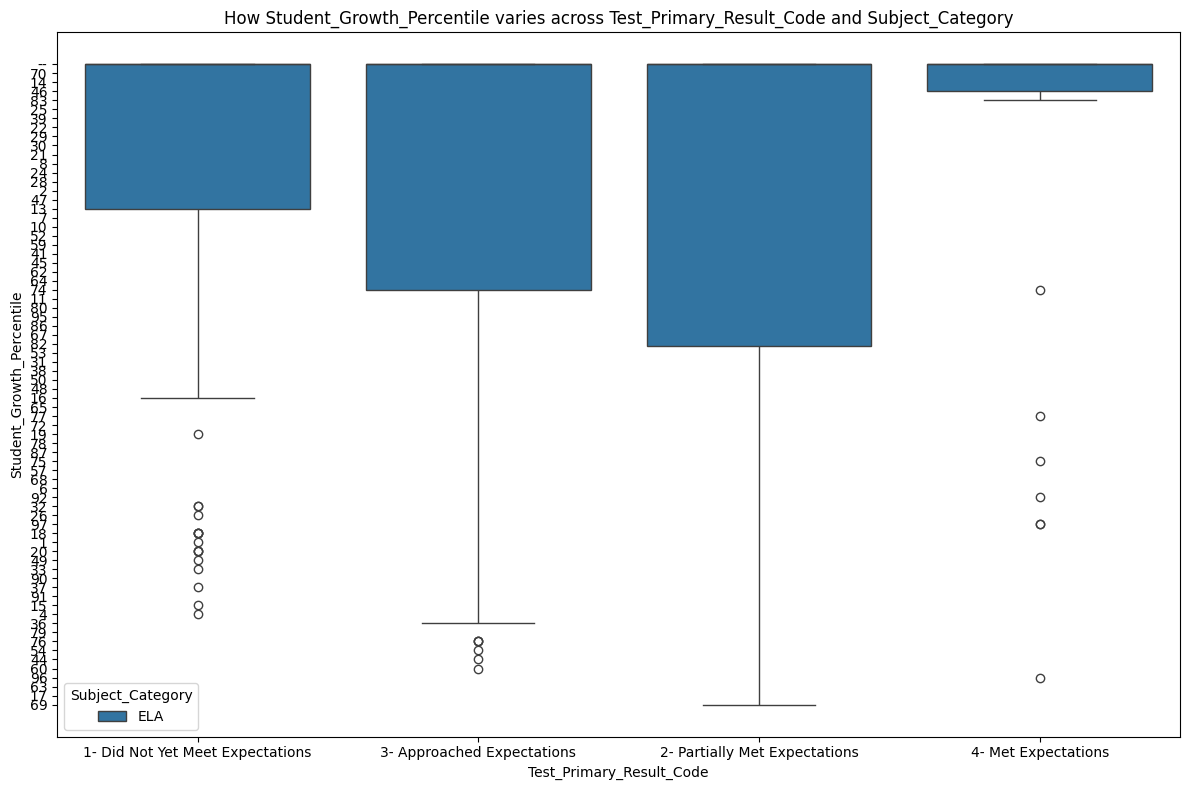

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot configuration
plt.figure(figsize=(12, 8))
sns.boxplot(
    x=vis_df['Test_Primary_Result_Code'],
    y=vis_df['Student_Growth_Percentile'],
    hue=vis_df['Subject_Category'],
    data=vis_df
)
plt.title('How Student_Growth_Percentile varies across Test_Primary_Result_Code and Subject_Category')
plt.xlabel('Test_Primary_Result_Code')
plt.ylabel('Student_Growth_Percentile')
plt.legend(title='Subject_Category')
plt.tight_layout()
plt.show()

In [ ]:
def generate_plot_from_question(df: pd.DataFrame, question: str, df_name: str = "df") -> str:
    """
    Generates matplotlib or seaborn visualization code based on a question
    and the columns specified in parentheses.

    Args:
        df (pd.DataFrame): The DataFrame to visualize.
        question (str): The question, including referenced columns in parentheses.
        df_name (str): The name of the DataFrame to use in the generated code.

    Returns:
        str: Matplotlib or seaborn code for the visualization.
    """
    # Extract column names from the parentheses
    match = re.search(r"\((.*?)\)", question)
    if not match:
        return "No columns found in parentheses in the question."

    columns = [col.strip() for col in match.group(1).split(",")]

    # Ensure columns exist in the DataFrame
    missing_cols = [col for col in columns if col not in df.columns]
    if missing_cols:
        return f"Columns {missing_cols} not found in the DataFrame."

    # Handle correlation questions with derived columns
    if "correlation" in question.lower():
        if len(columns) == 2:
            # Standard correlation question
            col1, col2 = columns
            plot_code = f"""
import matplotlib.pyplot as plt
import seaborn as sns

# Plot configuration
plt.figure(figsize=(10, 6))
sns.scatterplot(x={df_name}['{col1}'], y={df_name}['{col2}'])
plt.title('Correlation between {col1} and {col2}')
plt.xlabel('{col1}')
plt.ylabel('{col2}')
plt.tight_layout()
plt.show()
"""
            return plot_code
        elif len(columns) == 3:
            # Derived correlation case: compute the derived column first
            derived_col = "Change_in_Test_Scaled_Score"
            col1, col2, time_col = columns
            plot_code = f"""
import matplotlib.pyplot as plt
import seaborn as sns

# Compute derived column
{df_name}['{derived_col}'] = {df_name}.groupby('{time_col}')['{col2}'].diff()

# Plot configuration
plt.figure(figsize=(10, 6))
sns.scatterplot(x={df_name}['{col1}'], y={df_name}['{derived_col}'])
plt.title('Correlation between {col1} and {derived_col}')
plt.xlabel('{col1}')
plt.ylabel('{derived_col}')
plt.tight_layout()
plt.show()
"""
            return plot_code
        else:
            return "Correlation questions should reference two columns or include a derived column."

    # If no valid visualization type is detected
    return "Unable to determine the visualization type based on the question."


In [ ]:
# Define the question
question = ("What is the correlation between student growth percentile and the change "
            "in test scaled score from the previous year? (Student_Growth_Percentile, Test_Scaled_Score, Year)")

# Call the function with the DataFrame
plot_code = generate_plot_from_question(vis_df, question, df_name="vis_df")

# Print the generated code
print(plot_code)



import matplotlib.pyplot as plt
import seaborn as sns

# Compute derived column
vis_df['Change_in_Test_Scaled_Score'] = vis_df.groupby('Year')['Test_Scaled_Score'].diff()

# Plot configuration
plt.figure(figsize=(10, 6))
sns.scatterplot(x=vis_df['Student_Growth_Percentile'], y=vis_df['Change_in_Test_Scaled_Score'])
plt.title('Correlation between Student_Growth_Percentile and Change_in_Test_Scaled_Score')
plt.xlabel('Student_Growth_Percentile')
plt.ylabel('Change_in_Test_Scaled_Score')
plt.tight_layout()
plt.show()



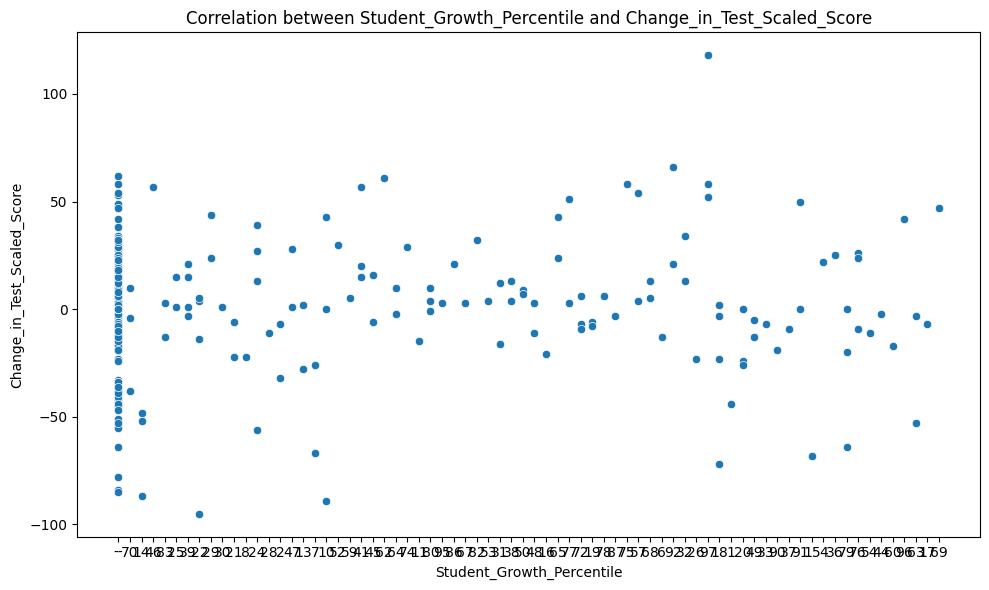

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Compute derived column
vis_df['Change_in_Test_Scaled_Score'] = vis_df.groupby('Year')['Test_Scaled_Score'].diff()

# Plot configuration
plt.figure(figsize=(10, 6))
sns.scatterplot(x=vis_df['Student_Growth_Percentile'], y=vis_df['Change_in_Test_Scaled_Score'])
plt.title('Correlation between Student_Growth_Percentile and Change_in_Test_Scaled_Score')
plt.xlabel('Student_Growth_Percentile')
plt.ylabel('Change_in_Test_Scaled_Score')
plt.tight_layout()
plt.show()

In [ ]:
def sample(query:str):
    # """Provides dataset-specific context for queries."""
    # project_id = "innosights"  # Define the project ID
    # location = "us"  # Define the location
    # qa_data_store_id = "qa-data-tool_1724784014475"
    # qa_data_store_path = f"projects/{project_id}/locations/{location}/collections/default_collection/dataStores/{qa_data_store_id}"

    # Initialize the model
    model = GenerativeModel("gemini-1.5-flash")

    # # Initialize the retrieval tool with the specific data store path
    # qa_data_tool = Tool.from_retrieval(
    #     grounding.Retrieval(grounding.VertexAISearch(datastore=qa_data_store_path))
    # )

    # Generate content using the model and retrieval tool
    response = model.generate_content(
        query,
        # tools=[qa_data_tool],
        generation_config=GenerationConfig(temperature=0.1),
    )

    # Return the generated content as text
    return response.text

In [ ]:
#sample("What is the python code to visualize the columns in parentheses: How does student growth percentile in mathematics vary across different performance levels in ELA? (Student_Growth_Percentile, Test_Primary_Result_Code, Subject_Category)")

In [ ]:
# import pandas as pd
# import matplotlib.pyplot as plt

# # Replace 'your_data.csv' with the actual path to your data file
# data = math_df

# # Filter data for mathematics
# math_data = data[data['Subject_Category'] == 'Mathematics']

# # Group data by performance level in ELA and calculate the mean student growth percentile
# grouped_data = math_data.groupby('Test_Primary_Result_Code')['Student_Growth_Percentile'].mean()

# # Create a bar chart
# plt.figure(figsize=(10, 6))
# plt.bar(grouped_data.index, grouped_data.values)

# # Set labels and title
# plt.xlabel('Performance Level in ELA')
# plt.ylabel('Average Student Growth Percentile in Mathematics')
# plt.title('How Does Student Growth Percentile in Mathematics Vary Across Different Performance Levels in ELA?')

# # Rotate x-axis labels for better readability
# plt.xticks(rotation=45)

# # Display the chart
# plt.show()

# # **Explanation:**

# # 1. **Import necessary libraries:**
# #    - `pandas` for data manipulation.
# #    - `matplotlib.pyplot` for plotting.

# # 2. **Load data:**
# #    - Replace `'your_data.csv'` with the actual path to your CSV file containing the data.

# # 3. **Filter for mathematics data:**
# #    - Select rows where `Subject_Category` is 'Mathematics'.

# # 4. **Group by ELA performance level:**
# #    - Use `groupby('Test_Primary_Result_Code')` to group the data by ELA performance levels.
# #    - Calculate the mean student growth percentile for each group using `['Student_Growth_Percentile'].mean()`.

# # 5. **Create bar chart:**
# #    - `plt.figure(figsize=(10, 6))` sets the figure size.
# #    - `plt.bar(grouped_data.index, grouped_data.values)` creates the bar chart with ELA performance levels on the x-axis and average student growth percentiles on the y-axis.

# # 6. **Set labels and title:**
# #    - `plt.xlabel()`, `plt.ylabel()`, and `plt.title()` add labels and a title to the chart.

# # 7. **Rotate x-axis labels:**
# #    - `plt.xticks(rotation=45)` rotates the x-axis labels for better readability if they are long.

# # 8. **Display the chart:**
# #    - `plt.show()` displays the created chart.

# # **Note:**

# # - Make sure your data file has columns named 'Student_Growth_Percentile', 'Test_Primary_Result_Code', and 'Subject_Category'.
# # - Adjust the code as needed based on your specific data and desired visualization.


In [ ]:
def generate_visualization_prompt(question: str, schema: str, df_name: str = "df") -> str:
    """
    Generates a structured prompt for an LLM to create Python visualization code.

    Args:
        question (str): The natural language question.
        schema (str): The schema of the DataFrame.
        df_name (str): The name of the DataFrame.

    Returns:
        str: A structured prompt for the LLM.
    """
    prompt = f"""
You are an expert in Python data visualization.

Given the following DataFrame schema:
{schema}

Write Python code using matplotlib or seaborn to visualize the columns specified in the parentheses of the question below.
Use the DataFrame named '{df_name}'. Your code should include:
- An appropriate plot type based on the question.
- Titles and labels for clarity.
- Any necessary preprocessing steps.

Question:
{question}

Example Question-to-Code Pair:
Question: What is the correlation between test scores and hours studied? (Test_Score, Hours_Studied)
Code:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.scatterplot(x=df['Test_Score'], y=df['Hours_Studied'])
plt.title('Correlation between Test_Score and Hours_Studied')
plt.xlabel('Test_Score')
plt.ylabel('Hours_Studied')
plt.tight_layout()
plt.show()

Now write the code for the provided question.
    """
    return prompt


In [ ]:
math_df.head()

,Student_Name,Student_ID,Annual_Grade,Test_Grade,Grade_Level_Current,Current_Homeroom,Tested_School,Current_School,Product,Test_Scaled_Score,Student_Growth_Percentile,Subject_Category,Test_Primary_Result_Code,Year
0,"Edwards, Makaya, A.",60052992,3,3,4,--,BASE,INNO,IAR,660,--,Mathematics,1- Did Not Yet Meet Expectations,2020-2021
1,"Washington, Malachi, E.",50392925,4,4,4,--,BASE,INNO,IAR,691,--,Mathematics,1- Did Not Yet Meet Expectations,2020-2021
2,"McMillian, Jaylon, D.",50537337,3,3,5,--,BASE,INNO,IAR,661,--,Mathematics,1- Did Not Yet Meet Expectations,2020-2021
3,"Luckie, Brilynn",50357791,4,4,6,--,BASE,INNO,IAR,724,--,Mathematics,2- Partially Met Expectations,2020-2021
4,"Carter, A'Nijah",60101350,5,5,6,--,BASE,INNO,IAR,703,--,Mathematics,2- Partially Met Expectations,2020-2021


In [ ]:
# Example usage
question = (
    "What is the correlation between student growth percentile and the change "
            "in test scaled score from the previous year? (Student_Growth_Percentile, Test_Scaled_Score, Year)"
)
schema = """
Student_Growth_Percentile: float
Test_Primary_Result_Code: category
Subject_Category: category
"""
prompt = generate_visualization_prompt(question, schema, df_name="math_df")


In [ ]:
# Example function to call the LLM
def get_visualization_code_from_llm(prompt: str) -> str:
    model = GenerativeModel("gemini-1.5-flash")
    response = model.generate_content(
        prompt, generation_config=GenerationConfig(temperature=0.1)
    )
    return response.text

# Get the visualization code
visualization_code = get_visualization_code_from_llm(prompt)

# Print the result
print(visualization_code)


```python
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have a DataFrame named 'math_df' with the necessary columns

# Preprocessing: Calculate the change in test scaled score from the previous year
math_df['Test_Scaled_Score_Change'] = math_df.groupby('Student_ID')['Test_Scaled_Score'].diff()

# Create the scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=math_df['Student_Growth_Percentile'], y=math_df['Test_Scaled_Score_Change'])
plt.title('Correlation between Student Growth Percentile and Test Scaled Score Change')
plt.xlabel('Student Growth Percentile')
plt.ylabel('Test Scaled Score Change from Previous Year')
plt.tight_layout()
plt.show()
```

**Explanation:**

1. **Preprocessing:**
   - We calculate the change in test scaled score from the previous year using `math_df.groupby('Student_ID')['Test_Scaled_Score'].diff()`. This assumes that your DataFrame has a 'Student_ID' column to identify individual students.
2. **Scatter Plot:**
   - We use `sns.

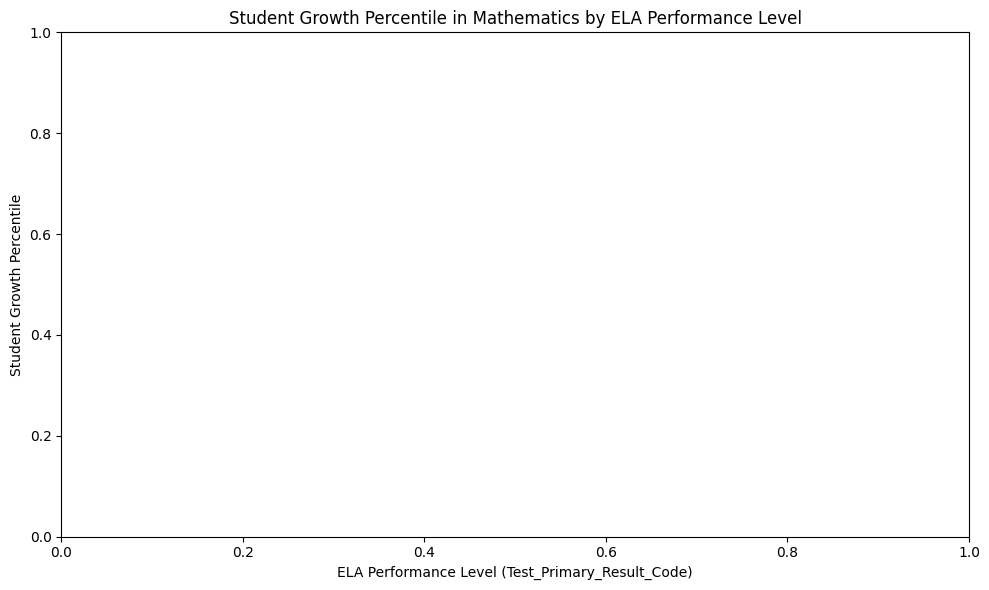

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'math_df' is your DataFrame

# Filter for ELA subject
ela_df = math_df[math_df['Subject_Category'] == 'ELA']

# Create the boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Test_Primary_Result_Code', y='Student_Growth_Percentile', data=ela_df)

# Set title and labels
plt.title('Student Growth Percentile in Mathematics by ELA Performance Level')
plt.xlabel('ELA Performance Level (Test_Primary_Result_Code)')
plt.ylabel('Student Growth Percentile')

plt.tight_layout()
plt.show()

In [ ]:
def generate_visualization_prompt_without_schema(question: str, df_name: str = "df") -> str:
    """
    Generates a prompt for an LLM to create Python visualization code without knowing the schema.

    Args:
        question (str): The natural language question.
        df_name (str): The name of the DataFrame.

    Returns:
        str: A structured prompt for the LLM.
    """
    import re
    # Extract column names from the question
    match = re.search(r"\((.*?)\)", question)
    if not match:
        raise ValueError("No columns found in parentheses in the question.")

    columns = [col.strip() for col in match.group(1).split(",")]

    # Generate the prompt
    prompt = f"""
You are an expert in Python data visualization.

Write Python code using matplotlib or seaborn to visualize the columns specified in the parentheses of the question below.
Assume the DataFrame is named '{df_name}' and contains the following columns: {', '.join(columns)}.
If preprocessing is required (e.g., calculating a derived column), include it in the code.
Ensure the code includes:
- An appropriate plot type based on the question.
- Titles and labels for clarity.

Question:
{question}

Example Question-to-Code Pair:
Question: What is the correlation between test scores and hours studied? (Test_Score, Hours_Studied)
Code:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.scatterplot(x={df_name}['Test_Score'], y={df_name}['Hours_Studied'])
plt.title('Correlation between Test_Score and Hours_Studied')
plt.xlabel('Test_Score')
plt.ylabel('Hours_Studied')
plt.tight_layout()
plt.show()

Now write the code for the provided question.
    """
    return prompt


In [ ]:
question = (
    "What is the correlation between student growth percentile and the change "
            "in test scaled score from the previous year? (Student_Growth_Percentile, Test_Scaled_Score, Year)"
)

# Generate prompt without schema
prompt = generate_visualization_prompt_without_schema(question, df_name="vis_df")

# Feed prompt to the LLM
visualization_code = get_visualization_code_from_llm(prompt)

# Print the result
print(visualization_code)


```python
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming 'vis_df' is your DataFrame

# Calculate the change in test scaled score from the previous year
vis_df['Test_Scaled_Score_Change'] = vis_df.groupby('Student_Growth_Percentile')['Test_Scaled_Score'].transform(lambda x: x.diff())

# Filter out the first year for each student since there's no previous year data
vis_df = vis_df[vis_df['Test_Scaled_Score_Change'].notna()]

# Create the scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=vis_df['Student_Growth_Percentile'], y=vis_df['Test_Scaled_Score_Change'])
plt.title('Correlation between Student Growth Percentile and Change in Test Scaled Score')
plt.xlabel('Student Growth Percentile')
plt.ylabel('Change in Test Scaled Score')
plt.tight_layout()
plt.show()
```



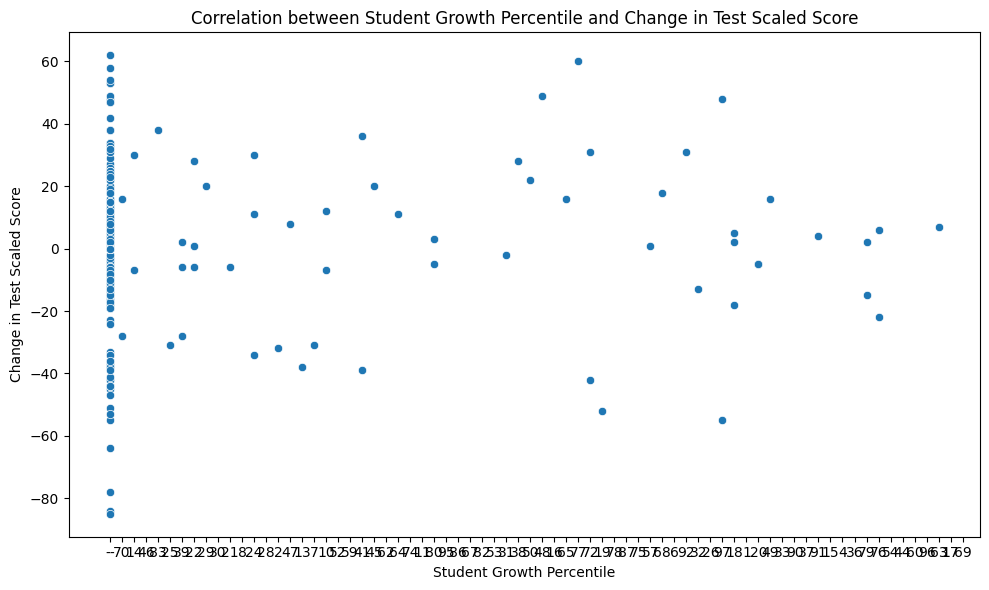

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming 'vis_df' is your DataFrame

# Calculate the change in test scaled score from the previous year
vis_df['Test_Scaled_Score_Change'] = vis_df.groupby('Student_Growth_Percentile')['Test_Scaled_Score'].transform(lambda x: x.diff())

# Create a scatter plot to visualize the correlation
plt.figure(figsize=(10, 6))
sns.scatterplot(x=vis_df['Student_Growth_Percentile'], y=vis_df['Test_Scaled_Score_Change'])
plt.title('Correlation between Student Growth Percentile and Change in Test Scaled Score')
plt.xlabel('Student Growth Percentile')
plt.ylabel('Change in Test Scaled Score')
plt.tight_layout()
plt.show()

In [ ]:
def generate_visualization_prompt_with_dynamic_schema(df, question: str, df_name: str = "df") -> str:
    """
    Generates a structured prompt for an LLM to create Python visualization code
    using dynamically extracted DataFrame schema.

    Args:
        df (pd.DataFrame): The DataFrame to inspect.
        question (str): The natural language question.
        df_name (str): The name of the DataFrame.

    Returns:
        str: A structured prompt for the LLM.
    """
    # Extract DataFrame schema
    schema = "\n".join([f"{col}: {dtype}" for col, dtype in df.dtypes.items()])

    # Generate the prompt
    prompt = f"""
You are an expert in Python data visualization.

Given the following DataFrame schema:
{schema}

Write Python code using matplotlib or seaborn to visualize the columns specified in the parentheses of the question below.
Use the DataFrame named '{df_name}'. Your code should include:
- An appropriate plot type based on the question.
- Titles and labels for clarity.
- Any necessary preprocessing steps.

Question:
{question}

Example Question-to-Code Pair:
Question: What is the correlation between test scores and hours studied? (Test_Score, Hours_Studied)
Code:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.scatterplot(x={df_name}['Test_Score'], y={df_name}['Hours_Studied'])
plt.title('Correlation between Test_Score and Hours_Studied')
plt.xlabel('Test_Score')
plt.ylabel('Hours_Studied')
plt.tight_layout()
plt.show()

Now write the code for the provided question.
    """
    return prompt


In [ ]:
question = (
    "What is the correlation between student growth percentile and the change "
            "in test scaled score from the previous year? (Student_Growth_Percentile, Test_Scaled_Score, Year)"
)


In [ ]:
prompt = generate_visualization_prompt_with_dynamic_schema(vis_df, question, df_name="vis_df")
print(prompt)



You are an expert in Python data visualization.

Given the following DataFrame schema:
Student_Name: object
Student_ID: int64
Annual_Grade: int64
Test_Grade: int64
Grade_Level_Current: int64
Current_Homeroom: object
Tested_School: object
Current_School: object
Product: object
Test_Scaled_Score: int64
Student_Growth_Percentile: object
Subject_Category: object
Test_Primary_Result_Code: object
Year: object
Change_in_Test_Scaled_Score: float64
Test_Scaled_Score_Change: float64

Write Python code using matplotlib or seaborn to visualize the columns specified in the parentheses of the question below.
Use the DataFrame named 'vis_df'. Your code should include:
- An appropriate plot type based on the question.
- Titles and labels for clarity.
- Any necessary preprocessing steps.

Question:
What is the correlation between student growth percentile and the change in test scaled score from the previous year? (Student_Growth_Percentile, Test_Scaled_Score, Year)

Example Question-to-Code Pair:
Que

In [ ]:
sample(prompt)

"```python\nimport matplotlib.pyplot as plt\nimport seaborn as sns\n\n# Assuming 'vis_df' is your DataFrame\n\n# Preprocessing: Convert 'Student_Growth_Percentile' to numeric\nvis_df['Student_Growth_Percentile'] = pd.to_numeric(vis_df['Student_Growth_Percentile'], errors='coerce')\n\n# Filter for valid data\nvis_df = vis_df.dropna(subset=['Student_Growth_Percentile', 'Test_Scaled_Score_Change'])\n\n# Create the scatter plot\nplt.figure(figsize=(10, 6))\nsns.scatterplot(x='Student_Growth_Percentile', y='Test_Scaled_Score_Change', data=vis_df, hue='Year')\nplt.title('Correlation between Student Growth Percentile and Change in Test Scaled Score')\nplt.xlabel('Student Growth Percentile')\nplt.ylabel('Change in Test Scaled Score')\nplt.tight_layout()\nplt.show()\n```\n\nThis code does the following:\n\n1. **Preprocessing:**\n   - Converts the 'Student_Growth_Percentile' column to numeric, handling potential errors.\n   - Removes rows with missing values in 'Student_Growth_Percentile' and 'T

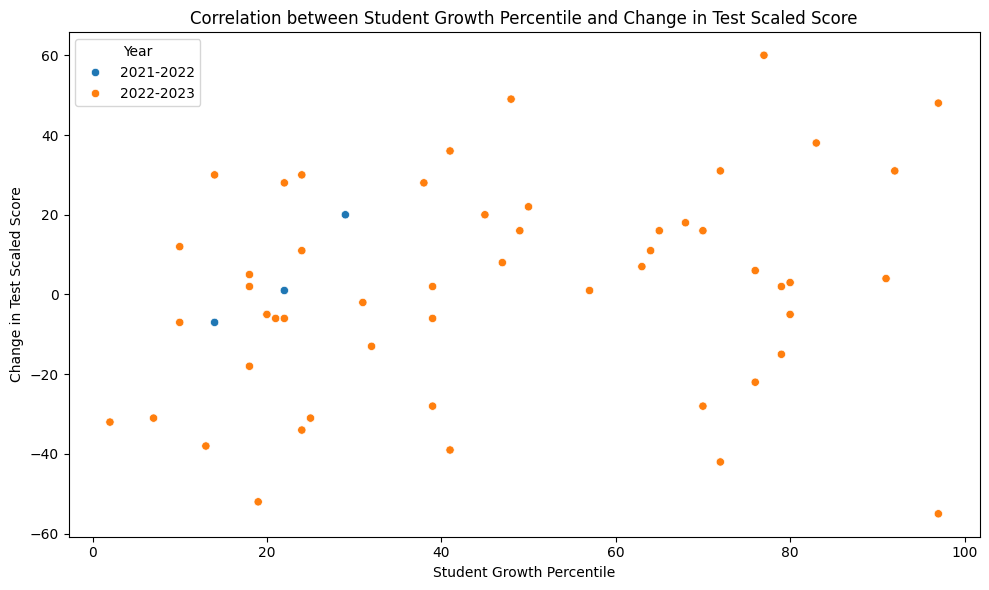

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'vis_df' is your DataFrame

# Preprocessing: Convert 'Student_Growth_Percentile' to numeric
vis_df['Student_Growth_Percentile'] = pd.to_numeric(vis_df['Student_Growth_Percentile'], errors='coerce')

# Filter for valid data
vis_df = vis_df.dropna(subset=['Student_Growth_Percentile', 'Test_Scaled_Score_Change'])

# Create the scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Student_Growth_Percentile', y='Test_Scaled_Score_Change', data=vis_df, hue='Year')
plt.title('Correlation between Student Growth Percentile and Change in Test Scaled Score')
plt.xlabel('Student Growth Percentile')
plt.ylabel('Change in Test Scaled Score')
plt.tight_layout()
plt.show()


# **Explanation:**

# 1. **Preprocessing:**
#    - We convert the 'Student_Growth_Percentile' column to numeric using `pd.to_numeric` with `errors='coerce'` to handle potential non-numeric values.
#    - We remove rows with missing values in 'Student_Growth_Percentile' and 'Test_Scaled_Score_Change' using `dropna`.

# 2. **Scatter Plot:**
#    - We use `sns.scatterplot` to create a scatter plot with:
#      - `x='Student_Growth_Percentile'`: The x-axis represents the student growth percentile.
#      - `y='Test_Scaled_Score_Change'`: The y-axis represents the change in test scaled score.
#      - `data=vis_df`: We use the preprocessed DataFrame.
#      - `hue='Year'`: We color-code the points based on the 'Year' column to visualize potential trends across different years.

# 3. **Labels and Title:**
#    - We set the title using `plt.title` to clearly describe the plot's purpose.
#    - We set the x and y axis labels using `plt.xlabel` and `plt.ylabel`.

# 4. **Layout:**
#    - `plt.tight_layout()` adjusts the plot layout to prevent overlapping elements.

# 5. **Display:**
#    - `plt.show()` displays the plot.

# This code will generate a scatter plot showing the relationship between student growth percentile and the change in test scaled score, with points colored by the year. This visualization helps you assess if there's a correlation between these two variables and how it might vary across different years.


In [ ]:
def generate_ag_charts_prompt(data: list, chart_id: str = "myChart") -> str:
    """
    Generates a prompt for creating an AG Charts bar chart with the provided data.

    Args:
        data (list): The dataset for the chart.
        chart_id (str): The HTML ID for the AG Chart container.

    Returns:
        str: A structured prompt for the LLM.
    """
    prompt = f"""
You are a JavaScript expert in interactive data visualization.

Write code to create an AG Charts bar chart using the following data:
{data}

The chart should:
- Use the AG Charts library.
- Plot the data as a bar chart.
- Include proper labels, titles, and axes configurations.

Use the following HTML container ID for the chart:
- Chart: '{chart_id}'

Include:
1. Initialization of the AG Charts library.
2. Proper configuration for the chart, including data binding, series setup, and visual styling.
3. The chart should resize automatically.

Example Data:
[
  {{ category: 'A', value: 10 }},
  {{ category: 'B', value: 15 }},
  {{ category: 'C', value: 20 }}
]
"""
    return prompt



In [ ]:
# Define the dataset
data = [
    { "category": "A", "value": 10 },
    { "category": "B", "value": 15 },
    { "category": "C", "value": 20 },
]

# Generate the AG Charts prompt
chart_prompt = generate_ag_charts_prompt(data, chart_id="myBarChart")
print(chart_prompt)



You are a JavaScript expert in interactive data visualization.

Write code to create an AG Charts bar chart using the following data:
[{'category': 'A', 'value': 10}, {'category': 'B', 'value': 15}, {'category': 'C', 'value': 20}]

The chart should:
- Use the AG Charts library.
- Plot the data as a bar chart.
- Include proper labels, titles, and axes configurations.

Use the following HTML container ID for the chart:
- Chart: 'myBarChart'

Include:
1. Initialization of the AG Charts library.
2. Proper configuration for the chart, including data binding, series setup, and visual styling.
3. The chart should resize automatically.

Example Data:
[
  { category: 'A', value: 10 },
  { category: 'B', value: 15 },
  { category: 'C', value: 20 }
]



In [ ]:
sample(chart_prompt)

'```html\n<!DOCTYPE html>\n<html>\n<head>\n  <title>AG Charts Bar Chart</title>\n  <script src="https://cdn.jsdelivr.net/npm/ag-charts-community@latest/dist/ag-charts-community.min.js"></script>\n  <style>\n    #myBarChart {\n      width: 100%;\n      height: 400px;\n    }\n  </style>\n</head>\n<body>\n  <div id="myBarChart"></div>\n\n  <script>\n    // Sample data\n    const data = [\n      { category: \'A\', value: 10 },\n      { category: \'B\', value: 15 },\n      { category: \'C\', value: 20 }\n    ];\n\n    // Initialize AG Charts\n    const chart = agCharts.AgChart.create({\n      container: \'myBarChart\',\n      autoSize: true, // Enable automatic resizing\n      theme: {\n        palette: {\n          fills: [\'#007bff\', \'#28a745\', \'#dc3545\'] // Example colors\n        }\n      },\n      title: {\n        text: \'Bar Chart Example\',\n        fontSize: 20\n      },\n      xAxis: {\n        label: {\n          text: \'Category\'\n        }\n      },\n      yAxis: {\n     

In [ ]:

# <!DOCTYPE html>
# <html>
# <head>
#   <title>AG Charts Bar Chart</title>
#   <script src="https://cdn.jsdelivr.net/npm/ag-charts-community@latest/dist/ag-charts-community.min.js"></script>
#   <style>
#     #myBarChart {
#       width: 100%;
#       height: 400px;
#     }
#   </style>
# </head>
# <body>
#   <div id="myBarChart"></div>

#   <script>
#     // Sample data
#     const data = [
#       { category: 'A', value: 10 },
#       { category: 'B', value: 15 },
#       { category: 'C', value: 20 }
#     ];

#     // Initialize AG Charts
#     const chart = agCharts.AgChart.create({
#       container: 'myBarChart',
#       autoSize: true,
#       theme: {
#         palette: {
#           fills: ['#007bff', '#28a745', '#dc3545'] // Example colors
#         }
#       },
#       title: {
#         text: 'Bar Chart Example',
#         fontSize: 20
#       },
#       series: [{
#         type: 'column',
#         data: data,
#         xKey: 'category',
#         yKey: 'value',
#         label: {
#           enabled: true,
#           formatter: (params) => params.dataItem.value
#         }
#       }],
#       axes: [{
#         type: 'category',
#         position: 'bottom',
#         title: {
#           text: 'Category'
#         }
#       }, {
#         type: 'number',
#         position: 'left',
#         title: {
#           text: 'Value'
#         }
#       }]
#     });
#   </script>
# </body>
# </html>


In [ ]:
# from IPython.core.display import display, HTML

# # HTML and JavaScript code
# html_code = """
# <!DOCTYPE html>
# <html>
# <head>
#   <title>AG Charts Bar Chart</title>
#   <script src="https://cdn.jsdelivr.net/npm/ag-charts-community/dist/ag-charts-community.min.js"></script>
#   <style>
#     #myBarChart {
#       height: 400px;
#       width: 600px;
#       margin: auto;
#     }
#   </style>
# </head>
# <body>
#   <h3>AG Charts Bar Chart</h3>
#   <div id="myBarChart"></div>

#   <script>
#     // Sample data
#     const data = [
#       { category: 'A', value: 10 },
#       { category: 'B', value: 15 },
#       { category: 'C', value: 20 }
#     ];

#     // AG Charts configuration
#     const chartOptions = {
#       container: document.getElementById('myBarChart'),
#       autoSize: true,
#       data: data,
#       series: [{
#         type: 'bar',
#         xKey: 'category',
#         yKey: 'value',
#         label: { enabled: true }
#       }],
#       title: { text: 'Category Values', fontSize: 18 },
#       axes: [
#         { type: 'category', position: 'bottom', title: { text: 'Category' } },
#         { type: 'number', position: 'left', title: { text: 'Value' } }
#       ]
#     };

#     // Initialize AG Charts
#     agCharts.AgChart.create(chartOptions);
#   </script>
# </body>
# </html>
# """


In [ ]:
# # Save HTML to a file
# output_file = "ag_charts_bar_chart.html"
# with open(output_file, "w") as f:
#     f.write(html_code)


In [ ]:
# from IPython.display import IFrame

# # Display the HTML file as an iframe
# IFrame(src=output_file, width=800, height=600)


In [ ]:
# from google.colab import files
# files.download(output_file)


In [ ]:
import plotly.express as px

# Sample data
data = [
    {"category": "A", "value": 10},
    {"category": "B", "value": 15},
    {"category": "C", "value": 20},
]

# Create a bar chart
fig = px.bar(
    data,
    x="category",
    y="value",
    title="Category Values",
    labels={"category": "Category", "value": "Value"},
    template="plotly_white"  # Clean, modern look similar to AG Charts
)

# Show the chart
fig.show()


In [ ]:
pip install ipywidgets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 16.2 MB/s eta 0:00:00


### AG Charts

In [ ]:
from IPython.core.display import display, HTML

# HTML and JavaScript for AG Charts
html_code = """
<!DOCTYPE html>
<html>
<head>
  <title>Student Attendance by Grade</title>
  <script src="https://cdn.jsdelivr.net/npm/ag-charts-community/dist/ag-charts-community.min.js"></script>
  <style>
    #myChart {
      width: 600px;
      height: 400px;
      margin: auto;
    }
  </style>
</head>
<body>
  <h3>Student Attendance by Grade</h3>
  <div id="myChart"></div>

  <script>
    // Sample data
    const data = [
      { grade: 'Grade 1', attendance_percentage: 95 },
      { grade: 'Grade 2', attendance_percentage: 90 },
      { grade: 'Grade 3', attendance_percentage: 85 },
      { grade: 'Grade 4', attendance_percentage: 80 },
      { grade: 'Grade 5', attendance_percentage: 88 }
    ];

    // AG Charts configuration
    const options = {
      container: document.getElementById('myChart'),
      autoSize: true,
      data: data,
      series: [{
        type: 'pie',
        angleKey: 'attendance_percentage',
        labelKey: 'grade',
        callout: { strokeWidth: 2 },
        innerRadiusRatio: 0.3  // Makes it a donut chart
      }],
      title: {
        text: 'Attendance Percentage by Grade',
        fontSize: 18
      }
    };

    // Render the chart
    agCharts.AgChart.create(options);
  </script>
</body>
</html>
"""

# Display the HTML in Google Colab
display(HTML(html_code))


In [ ]:
from IPython.core.display import display, HTML

# HTML and JavaScript for AG Charts
html_code = """
<!DOCTYPE html>
<html>
<head>
  <title>Average Test Scores by Subject</title>
  <script src="https://cdn.jsdelivr.net/npm/ag-charts-community/dist/ag-charts-community.min.js"></script>
  <style>
    #myChart {
      width: 600px;
      height: 400px;
      margin: auto;
    }
  </style>
</head>
<body>
  <h3>Average Test Scores by Subject</h3>
  <div id="myChart"></div>

  <script>
    // Sample data
    const data = [
      { month: 'January', math: 85, reading: 78, science: 88 },
      { month: 'February', math: 88, reading: 80, science: 85 },
      { month: 'March', math: 90, reading: 82, science: 87 },
      { month: 'April', math: 92, reading: 84, science: 89 },
      { month: 'May', math: 94, reading: 86, science: 90 }
    ];

    // AG Charts configuration
    const options = {
      container: document.getElementById('myChart'),
      autoSize: true,
      data: data,
      series: [
        { type: 'line', xKey: 'month', yKey: 'math', stroke: '#007bff', title: 'Math' },
        { type: 'line', xKey: 'month', yKey: 'reading', stroke: '#28a745', title: 'Reading' },
        { type: 'line', xKey: 'month', yKey: 'science', stroke: '#ffc107', title: 'Science' }
      ],
      axes: [
        { type: 'category', position: 'bottom', title: { text: 'Month' } },
        { type: 'number', position: 'left', title: { text: 'Average Score' } }
      ],
      title: {
        text: 'Average Test Scores by Subject Over Semester',
        fontSize: 18
      },
      legend: {
        position: 'bottom'
      }
    };

    // Render the chart
    agCharts.AgChart.create(options);
  </script>
</body>
</html>
"""

# Display the HTML in Google Colab
display(HTML(html_code))


### Chart Recommender

In [ ]:
def recommend_chart_type(question: str) -> str:
    """
    Recommends a visual chart type based on a given question using the Gemini model.

    Args:
        question (str): The question to analyze for visualization.

    Returns:
        str: A recommended chart type and explanation.
    """
    # Define the prompt
    prompt = f"""
    You are a data visualization expert. Your job is to recommend the most suitable type of chart
    based on a question. Analyze the question, determine what kind of data it implies, and recommend
    an appropriate chart type.

    Question: "{question}"

    Your recommendation should include:
    1. The chart type (e.g., bar chart, line chart, pie chart, scatter plot, etc.).
    2. A brief explanation of why this chart type is suitable for the question.

    Be concise and clear in your response.
    """

    # Initialize the model
    model = GenerativeModel("gemini-1.5-flash")

    # Generate content using the model
    response = model.generate_content(
        prompt,
        generation_config=GenerationConfig(temperature=0.1),
    )

    # Return the model's response as text
    return response.text


In [ ]:
# Example question
question = "Do students who attend the same school for both testing and current enrollment (Tested_School == Current_School) demonstrate higher growth (Student_Growth_Percentile) compared to students who have transferred schools?"

# Get chart recommendation
recommendation = recommend_chart_type(question)
print(recommendation)


## Recommendation: Box Plot

**Explanation:**

A box plot is the most suitable chart type for this question because it allows for a clear comparison of the distribution of student growth percentiles between two groups: students who attended the same school for both testing and enrollment, and students who transferred schools. 

* **Box plots visually represent the median, quartiles, and outliers of a dataset.** This helps to understand the central tendency and spread of student growth percentiles within each group.
* **Comparing the box plots side-by-side allows for easy visual comparison of the distributions.** This makes it simple to determine if there is a significant difference in growth percentiles between the two groups.

While other chart types like histograms or bar charts could be used, the box plot provides a more comprehensive and visually intuitive representation of the data distribution, making it easier to answer the question about growth differences between the two group

In [ ]:
def recommend_chart_types(question: str) -> str:
    """
    Recommends up to two suitable visualization types based on a given question using the Gemini model.

    Args:
        question (str): The question to analyze for visualization.

    Returns:
        str: Recommended chart types and explanations for each.
    """
    # Define the prompt
    prompt = f"""
    You are a data visualization expert. Your job is to recommend the two most suitable chart types
    based on a question. Analyze the question, determine what kind of data it implies, and recommend
    up to two visualization types.

    Question: "{question}"

    Your response should include:
    1. The top two recommended chart types (e.g., bar chart, line chart, pie chart, scatter plot, etc.).
    2. A brief explanation of why each chart type is suitable for the question.

    If only one chart type is clearly the best, explain why only one is sufficient. Use clear, concise,
    and non-technical language.
    """

    # Initialize the model
    model = GenerativeModel("gemini-1.5-flash")

    # Generate content using the model
    response = model.generate_content(
        prompt,
        generation_config=GenerationConfig(temperature=0.1),
    )

    # Return the model's response as text
    return response.text


In [ ]:
question = "What are the most common Test_Primary_Result_Codes for students who are identified as needing intervention (e.g., 'yellow' category)?"
# Example question
#question = "How does student attendance vary across grade levels and over the school year?"

# Get chart recommendations
recommendations = recommend_chart_types(question)
print(recommendations)


## Recommended Chart Types:

1. **Bar Chart:** A bar chart is the most suitable visualization for this question. It allows you to easily compare the frequency of different Test_Primary_Result_Codes for students needing intervention. The height of each bar would represent the number of students with that specific code, making it easy to identify the most common codes at a glance.

2. **Pie Chart:** While a pie chart could also be used to show the proportion of students with each Test_Primary_Result_Code, it might be less effective than a bar chart. This is because a pie chart is best for showing parts of a whole, and in this case, we are interested in comparing the frequency of different codes, not their proportion relative to each other.

**Why a bar chart is the best choice:**

A bar chart is the most effective way to visualize the frequency of different Test_Primary_Result_Codes. It allows for easy comparison between categories and clearly shows which codes are most common among stud

In [ ]:
import ipywidgets as widgets
from IPython.display import display, clear_output

# Define the backend function
def recommend_chart_types(question: str) -> str:
    """
    Recommends up to two suitable visualization types based on a given question using the Gemini model.
    """
    # Define the prompt
    prompt = f"""
    You are a data visualization expert. Your job is to recommend the two most suitable chart types
    based on a question. Analyze the question, determine what kind of data it implies, and recommend
    up to two visualization types.

    Question: "{question}"

    Your response should include:
    1. The top two recommended chart types (e.g., bar chart, line chart, pie chart, scatter plot, etc.).
    2. A brief explanation of why each chart type is suitable for the question.

    If only one chart type is clearly the best, explain why only one is sufficient. Use clear, concise,
    and non-technical language.
    """

    # Initialize the model
    model = GenerativeModel("gemini-1.5-flash")

    # Generate content using the model
    response = model.generate_content(
        prompt,
        generation_config=GenerationConfig(temperature=0.1),
    )

    # Return the model's response as text
    return response.text

# UI components
question_input = widgets.Textarea(
    placeholder="Enter your question here",
    description="Question:",
    layout=widgets.Layout(width='100%', height='100px')
)

submit_button = widgets.Button(
    description="Get Recommendations",
    button_style="success"
)

output_area = widgets.Output()

# Define button click behavior
def on_submit_click(b):
    with output_area:
        clear_output()  # Clear previous output
        question = question_input.value.strip()
        if not question:
            print("Please enter a valid question.")
        else:
            print("Processing your question...")
            try:
                # Call the recommendation function
                recommendations = recommend_chart_types(question)
                clear_output(wait=True)  # Clear "Processing" message
                print(f"Recommendations:\n\n{recommendations}")
            except Exception as e:
                clear_output(wait=True)
                print(f"An error occurred: {e}")

# Attach behavior to button
submit_button.on_click(on_submit_click)

# Display the UI
display(widgets.VBox([question_input, submit_button, output_area]))


Please enter a valid question.


## Insights Generation

In [ ]:
def explain_visualization_code(code: str) -> str:
    """
    Generates a natural language explanation for a given piece of visualization code.

    Args:
        code (str): The visualization code to interpret and explain.

    Returns:
        str: A natural language explanation describing what the code does, including:
             - The type of chart or visualization being created.
             - The data being visualized (if evident from the code).
             - Key configurations like axes, labels, titles, or interactivity.
             - Any notable styling or customization.
    """
    prompt = f"""
You are a Python visualization expert and a skilled technical writer.

Here is a piece of visualization code:

{code}

Your task is to interpret this code and explain it in natural language. Your explanation should include:
1. What type of visualization is being created (e.g., bar chart, line chart, scatter plot, etc.).
2. The dataset or data structure being visualized (if the code provides data context).
3. Key configurations such as axes, labels, titles, and styles.
4. Whether the visualization has interactive features or any notable customizations.
5. If the code uses any specific libraries (e.g., matplotlib, Plotly, Bokeh), describe how those libraries are being used.

Provide the explanation in clear, concise, and beginner-friendly language.
    """
        # Initialize the model
    model = GenerativeModel("gemini-1.5-flash")


    # Generate content using the model and retrieval tool
    response = model.generate_content(
        prompt,
        generation_config=GenerationConfig(temperature=0.1),
    )

    return response.text


In [ ]:
explain_visualization_code("""
import plotly.express as px

# Sample data
data = [
    {"category": "A", "value": 10},
    {"category": "B", "value": 15},
    {"category": "C", "value": 20},
]

# Create a bar chart
fig = px.bar(
    data,
    x="category",
    y="value",
    title="Category Values",
    labels={"category": "Category", "value": "Value"},
    template="plotly_white"
)
fig.show()
""")


'This Python code creates a **bar chart** using the **Plotly** library. \n\n**Data:**\n\nThe code uses a simple list of dictionaries called `data` to represent the data. Each dictionary represents a data point with two keys: `category` and `value`. For example, the first dictionary `{"category": "A", "value": 10}` indicates that category "A" has a value of 10.\n\n**Visualization:**\n\nThe `px.bar()` function from the `plotly.express` module is used to create the bar chart. \n\n* **`x="category"`:** This sets the "category" values as the x-axis labels.\n* **`y="value"`:** This sets the "value" values as the heights of the bars.\n* **`title="Category Values"`:** This sets the title of the chart.\n* **`labels={"category": "Category", "value": "Value"}`:** This customizes the axis labels to be more descriptive.\n* **`template="plotly_white"`:** This applies a clean white background theme to the chart.\n\n**Interactive Features:**\n\nPlotly charts are interactive by default. This means you 

In [ ]:
def explain_visualization_code_with_action(code: str) -> str:
    """
    Generates a natural language explanation for a given piece of visualization code,
    including a suggestion or action for improvement, and focuses on clear communication
    for a non-technical audience.

    Args:
        code (str): The visualization code to interpret and explain.

    Returns:
        str: A natural language explanation describing what the code does, insights from the visualization,
             and an actionable suggestion for improvement.
    """
    prompt = f"""
You are a Python visualization expert and a skilled communicator for non-technical audiences.

Here is a piece of visualization code:

{code}

Your task is to interpret this code and provide the following:
1. Explain the type of visualization being created (e.g., bar chart, line chart, scatter plot, etc.).
2. Clearly describe the data being visualized, focusing on key trends, patterns, or insights.
3. Use clear, concise, and easy-to-understand language. Avoid technical jargon and complex statistical terms.
4. Include **one actionable suggestion or action** to improve outcomes or address the trends shown in the visualization.

Instructions:
- Use plain language and simple sentence structures.
- Focus on how to communicate insights to a non-data-savvy audience.
- Example of a **good explanation**:
  "As you can see from this chart, our students' math scores have been steadily improving over the past three years. However, their reading scores have remained relatively flat. This suggests that we may need to allocate more resources to reading instruction."
- Example of a **bad explanation**:
  "The variance analysis reveals a significant difference in the mean scores between the experimental and control groups. This finding suggests that the new instructional method has a positive impact on student achievement."

Generate the explanation in clear, actionable language.
    """
    # Initialize the model
    model = GenerativeModel("gemini-1.5-flash")

    # Generate content using the model
    response = model.generate_content(
        prompt,
        generation_config=GenerationConfig(temperature=0.1),
    )

    return response.text


In [ ]:
import plotly.express as px

# Sample data
data = [
    {"category": "A", "value": 10},
    {"category": "B", "value": 15},
    {"category": "C", "value": 20},
]

# Create a bar chart
fig = px.bar(
    data,
    x="category",
    y="value",
    title="Category Values",
    labels={"category": "Category", "value": "Value"},
    template="plotly_white"
)
fig.show()

In [ ]:
explain_visualization_code_with_action("""
import plotly.express as px

# Sample data
data = [
    {"category": "A", "value": 10},
    {"category": "B", "value": 15},
    {"category": "C", "value": 20},
]

# Create a bar chart
fig = px.bar(
    data,
    x="category",
    y="value",
    title="Category Values",
    labels={"category": "Category", "value": "Value"},
    template="plotly_white"
)
fig.show()
""")


'This code creates a **bar chart** to show the values of different categories. \n\nThe chart displays three categories: A, B, and C.  Category A has a value of 10, Category B has a value of 15, and Category C has a value of 20.  This means that Category C has the highest value, followed by Category B, and then Category A.\n\n**Actionable Suggestion:**  Since Category C has the highest value, it might be beneficial to investigate why this category is performing so well.  Understanding the factors contributing to its success could help improve the performance of the other categories. \n'

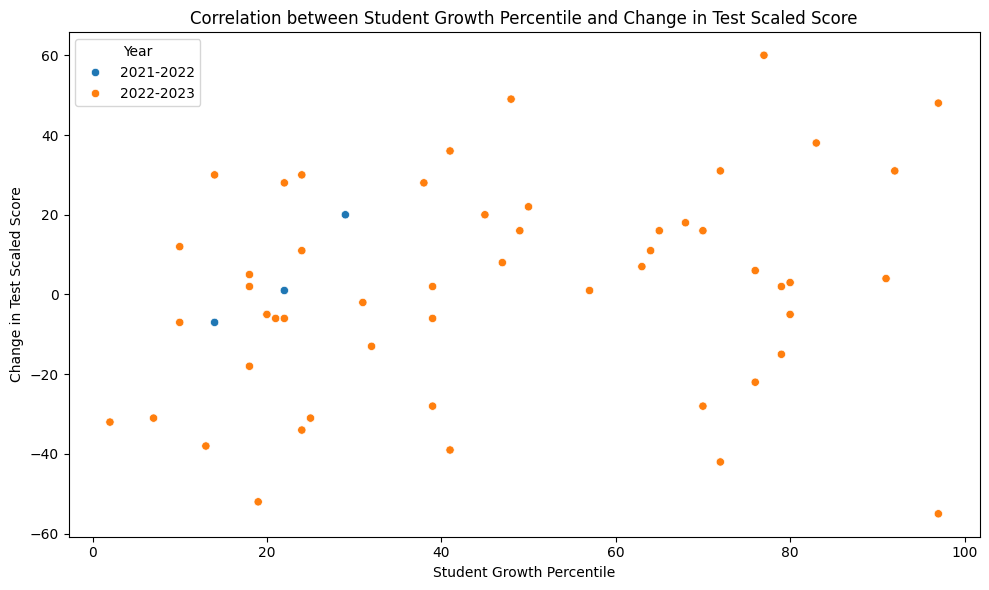

In [ ]:
    import matplotlib.pyplot as plt
    import seaborn as sns

    # Assuming 'vis_df' is your DataFrame

    # Preprocessing: Convert 'Student_Growth_Percentile' to numeric
    vis_df['Student_Growth_Percentile'] = pd.to_numeric(vis_df['Student_Growth_Percentile'], errors='coerce')

    # Filter for valid data
    vis_df = vis_df.dropna(subset=['Student_Growth_Percentile', 'Test_Scaled_Score_Change'])

    # Create the scatter plot
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='Student_Growth_Percentile', y='Test_Scaled_Score_Change', data=vis_df, hue='Year')
    plt.title('Correlation between Student Growth Percentile and Change in Test Scaled Score')
    plt.xlabel('Student Growth Percentile')
    plt.ylabel('Change in Test Scaled Score')
    plt.tight_layout()
    plt.show()

In [ ]:
explain_visualization_code_with_action("""
    import matplotlib.pyplot as plt
    import seaborn as sns

    # Assuming 'vis_df' is your DataFrame

    # Preprocessing: Convert 'Student_Growth_Percentile' to numeric
    vis_df['Student_Growth_Percentile'] = pd.to_numeric(vis_df['Student_Growth_Percentile'], errors='coerce')

    # Filter for valid data
    vis_df = vis_df.dropna(subset=['Student_Growth_Percentile', 'Test_Scaled_Score_Change'])

    # Create the scatter plot
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='Student_Growth_Percentile', y='Test_Scaled_Score_Change', data=vis_df, hue='Year')
    plt.title('Correlation between Student Growth Percentile and Change in Test Scaled Score')
    plt.xlabel('Student Growth Percentile')
    plt.ylabel('Change in Test Scaled Score')
    plt.tight_layout()
    plt.show()
    """)

"This code creates a **scatter plot**, which is a type of graph that shows the relationship between two different pieces of data. \n\nIn this case, the scatter plot is showing the relationship between **student growth percentile** (how much a student has improved over time) and **change in test scaled score** (how much a student's test score has gone up or down). The color of each dot on the graph represents the **year** the data was collected.\n\n**Here's what we can see from the graph:**\n\n* **There seems to be a general trend:** Students who have higher growth percentiles tend to have larger increases in their test scores. This makes sense, as students who are improving more are likely to see better results on their tests.\n* **The data points are spread out:** This means that there isn't a perfect relationship between growth percentile and test score change. Some students with high growth percentiles might not see big changes in their test scores, and vice versa.\n* **The color of

In [ ]:
import plotly.express as px
import pandas as pd

# Sample data
data = [
    {"grade": "Grade 1", "attendance_percentage": 95},
    {"grade": "Grade 2", "attendance_percentage": 90},
    {"grade": "Grade 3", "attendance_percentage": 85},
    {"grade": "Grade 4", "attendance_percentage": 80},
    {"grade": "Grade 5", "attendance_percentage": 88},
]

# Create a DataFrame
df = pd.DataFrame(data)

# Create a pie chart
fig = px.pie(
    df,
    names="grade",
    values="attendance_percentage",
    title="Attendance Percentage by Grade",
    hole=0.3,  # Optional: Add a hole in the center for a donut chart effect
)

# Show the chart
fig.show()


In [ ]:
explain_visualization_code_with_action("""
import plotly.express as px
import pandas as pd

# Sample data
data = [
    {"grade": "Grade 1", "attendance_percentage": 95},
    {"grade": "Grade 2", "attendance_percentage": 90},
    {"grade": "Grade 3", "attendance_percentage": 85},
    {"grade": "Grade 4", "attendance_percentage": 80},
    {"grade": "Grade 5", "attendance_percentage": 88},
]

# Create a DataFrame
df = pd.DataFrame(data)

# Create a pie chart
fig = px.pie(
    df,
    names="grade",
    values="attendance_percentage",
    title="Attendance Percentage by Grade",
    hole=0.3,  # Optional: Add a hole in the center for a donut chart effect
)

# Show the chart
fig.show()
""")

"This code creates a **pie chart** that shows the attendance percentage for each grade level. \n\nThe chart reveals that **Grade 1 has the highest attendance percentage at 95%**, followed by Grade 2 at 90%. Attendance gradually decreases as students progress through the grades, with Grade 4 having the lowest attendance at 80%. \n\n**Actionable Suggestion:**  The declining attendance trend as students get older suggests that there might be factors impacting older students' attendance.  It would be helpful to investigate the reasons behind this trend, such as potential issues with curriculum, student engagement, or family circumstances. Addressing these issues could help improve attendance rates for older students. \n"